### RUNNER

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '../')

In [2]:
from crossvalidation.csv_input_manager import CSVInputManager
from input_manager.nrel_input_manager import NRELInputManager
from models.ml.KNNRegressor import KNNRegressor
from models.ml.DecisionTreeRegressor import RDecisionTree
from models.ml.RSupportVector import RSupportVector
from models.ml.RLSTM import RLSTM
from crossvalidation.train_test_split import TrainTestSplit
# from models.neural_networks.svr.SVR import SVRRegresion
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from configparser import ConfigParser
import pandas as pd
import numpy as np

from model_runner import FileConfigManager,OutputManager,LocalRunner,TrainOperation,TestOperation,Experiment

/home/ycedres/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
# CONFIGURATION MANAGER
config_file_name = '/home/ycedres/Projects/RNN/RNN-windPower/src/regressors/core/config.ini'

file_config_manager = FileConfigManager(filename=config_file_name)
basedir = file_config_manager.get_input_basedir()
filename = file_config_manager.get_input_filename()

# OUTPUT MANAGER
output_manager = OutputManager()

# RUNNER
local_runner = LocalRunner()

# INPUT MANAGER
input_manager = NRELInputManager()
input_manager.configure_load_datasource(method='filesystem',
filename=basedir+filename)

features = file_config_manager.get_features_config()

# import sys
# sys.exit()
output_filename = 'ws'+features['window_size'] + '_' + \
                  'h'+features['horizon'] + '_' + \
                  'p'+features['padding'] + '_' + \
                  'sz'+features['step_size'] + '_' + \
                  features['method'] +\
                  '.csv'

input_manager.configure_features_generator(
    window_size=int(features['window_size']),
    horizon=int(features['horizon']),
    padding=int(features['padding']),
    step_size=int(features['step_size']),
    write_csv_file=True,
    output_csv_file=file_config_manager.get_output_basedir()+
                    output_filename,
    #method='sequential',
    method=features['method']
)

In [4]:
input_manager.load_and_split()

<class 'dict'>
#################################################
SEQUENTIAL
len(ts): 26304
window size: 6
padding: 0
horizon: 1
upper_bound: 26298
lower_bound: 0
step_size: 1
steps: 26298
#################################################


In [5]:
output_manager.set_output_config(
    save = False
)

experiment_svr = Experiment(config_manager=file_config_manager,
                            input_manager=input_manager,
                            output_manager=output_manager,
                            runner=local_runner)

In [6]:
svr = RSupportVector()
svr_train_operation = TrainOperation(svr)
experiment_svr.run_train_operation(svr_train_operation)

svr_test_operation = TestOperation(svr)

experiment_svr.run_test_operation(svr_test_operation)

/home/ycedres/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


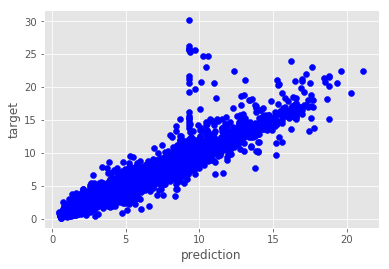

In [7]:
experiment_svr.plot(type='scatter')

### ENTRENAR CON DATOS PROPORCIONADOS POR EL INPUT MANAGER

In [8]:
features_train_set = input_manager.get_train_features()
target_train_set = input_manager.get_train_target()

features_test_set = input_manager.get_test_features()
target_test_set = input_manager.get_test_target()

features_validation_set = input_manager.get_validation_features()
target_validation_set = input_manager.get_validation_target()

In [9]:
from sklearn.svm import SVR
clf = SVR(C=9,gamma='auto',kernel='rbf')
clf.fit(features_train_set, target_train_set)

/home/ycedres/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=9, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [10]:
predicted = clf.predict(features_test_set)

In [11]:
df_prediction = input_manager.get_test_target()
df_prediction['target_predicted'] = predicted

/home/ycedres/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


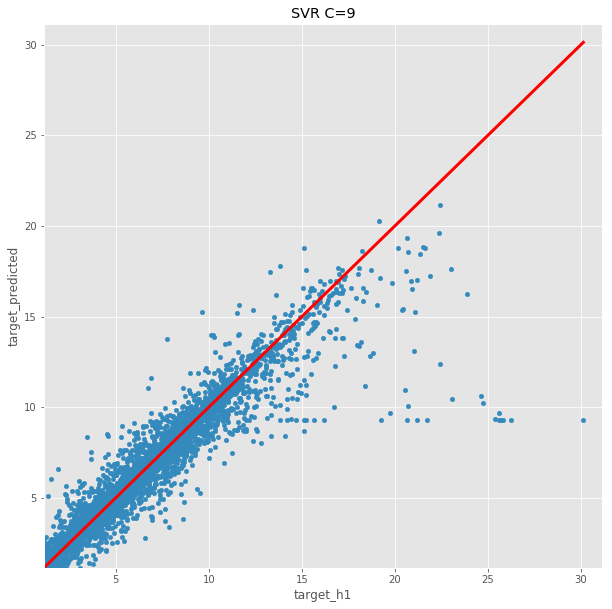

In [12]:
title='SVR C=9'

f, ax = plt.subplots(1,1,figsize=(10,10))
x_min = df_prediction.target_h1.min() 
x_max = df_prediction.target_h1.max()
y_min = df_prediction.target_predicted.min()
y_max = df_prediction.target_predicted.max()
ax.set_title(title)
# line
ax.set_xlim(x_min+1, x_max+1)
ax.set_ylim(x_min+1, x_max+1)
ax.plot((x_min, x_max), (x_min, x_max), lw=3, c='r')
# scatter
df_prediction.plot(ax=ax,
                   x='target_h1',
                   y='target_predicted',
                   kind='scatter',
                  )

### ENTRENAR CON DATOS PROPORCIONADO POR EL INPUT MANAGER (VERSION 2)

In [13]:
train_set = input_manager.get_train_features()
validation_set = input_manager.get_validation_features()
test_set = input_manager.get_test_features()

In [14]:
features_columns = train_set.columns[1:-1]
target_column = train_set.columns[-1:]

In [15]:
features_train_set = train_set[features_columns]
target_train_set = train_set[target_column]

features_validation_set = validation_set[features_columns]
target_validation_set = validation_set[target_column]

features_test_set = test_set[features_columns]
target_test_set = test_set[target_column]

In [16]:
clf = SVR(C=9,gamma='auto',kernel='rbf')
clf.fit(features_train_set, target_train_set)

/home/ycedres/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=9, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [17]:
predicted = clf.predict(features_test_set)
df_prediction = test_set.copy()
df_prediction['target_h1'] = input_manager.get_test_target()
df_prediction['target_predicted'] = predicted

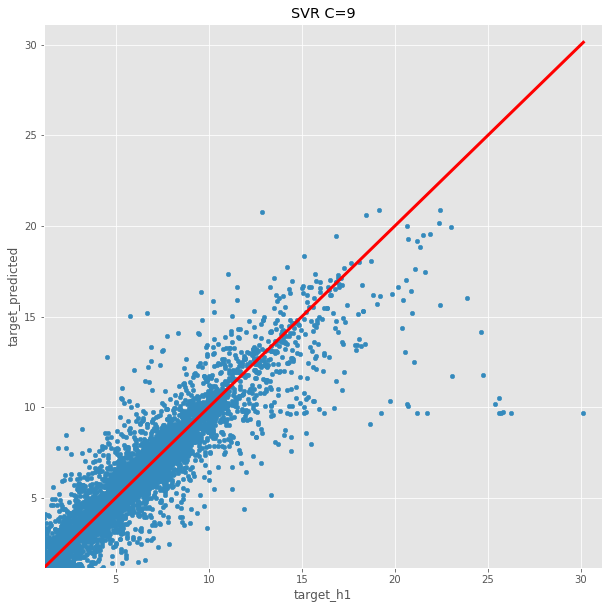

In [18]:
title='SVR C=9'

f, ax = plt.subplots(1,1,figsize=(10,10))
x_min = df_prediction.target_h1.min() 
x_max = df_prediction.target_h1.max()
y_min = df_prediction.target_predicted.min()
y_max = df_prediction.target_predicted.max()
ax.set_title(title)
# line
ax.set_xlim(x_min+1, x_max+1)
ax.set_ylim(x_min+1, x_max+1)
ax.plot((x_min, x_max), (x_min, x_max), lw=3, c='r')
# scatter
df_prediction.plot(ax=ax,
                   x='target_h1',
                   y='target_predicted',
                   kind='scatter',
                  )

### Ejecutar MODELO DEL RUNNER manualmente

In [19]:
svr = RSupportVector()

In [20]:
features_train_set = input_manager.get_train_features()
target_train_set = input_manager.get_train_target()

features_test_set = input_manager.get_test_features()
target_test_set = input_manager.get_test_target()

features_validation_set = input_manager.get_validation_features()
target_validation_set = input_manager.get_validation_target()

In [21]:
svr.train(features_train_set,
                    target_train_set,
                    features_validation_set,
                    target_validation_set)

/home/ycedres/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
predicted = svr.test(features_test_set)

In [23]:
df_prediction = test_set.copy()
df_prediction['target_h1'] = input_manager.get_test_target()
df_prediction['target_predicted'] = predicted

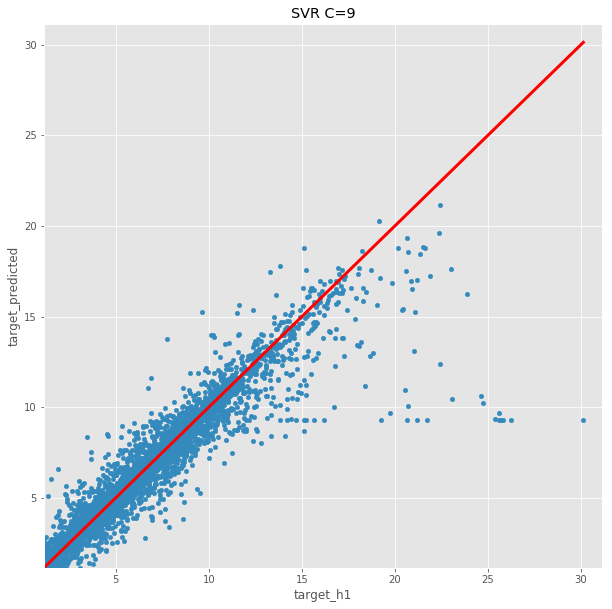

In [24]:
title='SVR C=9'

f, ax = plt.subplots(1,1,figsize=(10,10))
x_min = df_prediction.target_h1.min() 
x_max = df_prediction.target_h1.max()
y_min = df_prediction.target_predicted.min()
y_max = df_prediction.target_predicted.max()
ax.set_title(title)
# line
ax.set_xlim(x_min+1, x_max+1)
ax.set_ylim(x_min+1, x_max+1)
ax.plot((x_min, x_max), (x_min, x_max), lw=3, c='r')
# scatter
df_prediction.plot(ax=ax,
                   x='target_h1',
                   y='target_predicted',
                   kind='scatter',
                  )

In [35]:
from model_runner import OutputManager
output_manager_nuevo = OutputManager()
output_manager_nuevo.set_output_config(save = False)

In [42]:
output_manager_nuevo.set_df_prediction(predicted,input_manager.get_test_target())

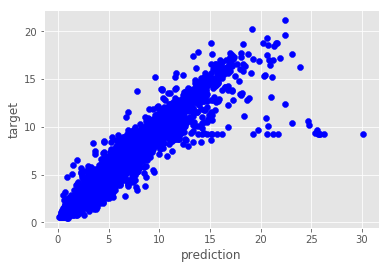

In [43]:
plt.xlabel('prediction')
plt.ylabel('target')
plt.scatter(x,y,c='b')